# Prediction of Treasury Yields

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import fmt
import utils as utl
import sympy as sp
sp.init_printing(use_latex = True)
from IPython.display import display
plt.style.use("ggplot")

Populating the interactive namespace from numpy and matplotlib


C:\Users\xiaog\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# extract the treasury yield data
main_dir = "C:/Users/xiaog/Dropbox/Mathematics_Finance/Capstone Investment Projects/program development"
sub_dir = "/data"
symbols = ["USTREASURY-YIELD"]
Treasury_yield = utl.data_preprocessing(main_dir, symbols, sub_dir)

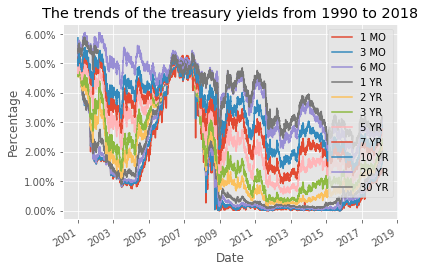

In [3]:
# visualize the treasury yields data
Treasury_yield_data = Treasury_yield["USTREASURY-YIELD"]
Treasury_yield_data = Treasury_yield_data.sort_index(ascending=True)
start_time = pd.Timestamp("2001-01-01")
ax = Treasury_yield_data.loc[start_time:].plot(title="The trends of the treasury yields from 1990 to 2018")
ax.set_ylabel("Percentage")
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.2f}%'.format(x) for x in vals])
plt.show()

In [4]:
# obtain the percentage changes
Treasury_yield_PCA = Treasury_yield_data.drop(labels=["30 YR"], axis=1)
Treasury_yield_PCA = Treasury_yield_PCA.dropna()
Treasury_yield_PCA_diff = Treasury_yield_PCA.diff().dropna()

### PCA analysis on the treasury yield return series and determination of market regime.


In [5]:
# perform the PCA analysis
days = 70
time_index, Treasury_integration = utl.PCA_analysis(Treasury_yield_PCA_diff, days)

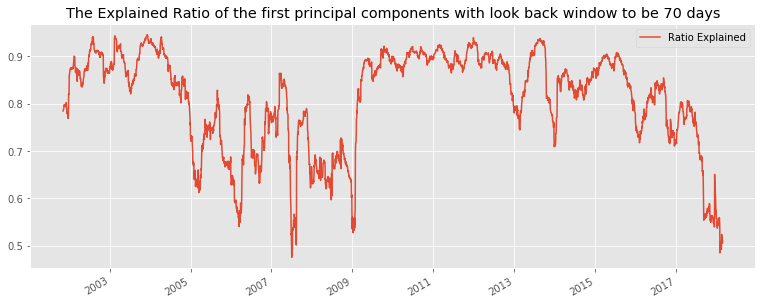

In [6]:
# Now we retrieve the explained variance ratio of the first principal component obtained from last step
explained_ratio = []
for key, value in Treasury_integration.items():
    explained_ratio.append(value[0][0])
    
explained_ratio = np.array(explained_ratio)
    
# build the pandas dataframe for explained variance ratio and plot them along the time
explained_ratio = pd.DataFrame(explained_ratio, index=time_index, columns=["Ratio Explained"])
ax = explained_ratio.plot(figsize = (13, 5))
ax.set_title("The Explained Ratio of the first principal components with look back window to be %d days" % days)
plt.show()

In [7]:
ratio_explained = utl.create_states(time_index, explained_ratio, 70, "2011-05-09")

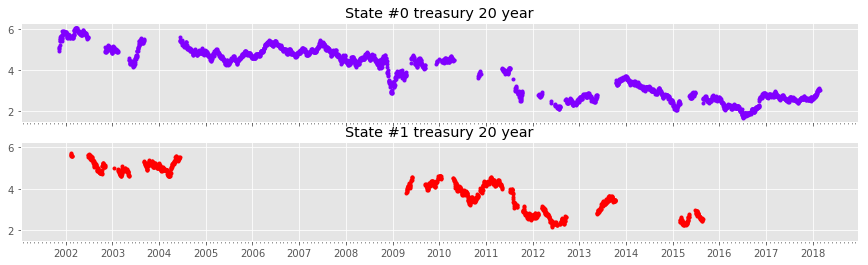

In [8]:
# visualize the state of PCA for the price movement of 20 year treasury 
Treasury_yield_20YR = Treasury_yield_PCA.loc[time_index[0]:]["20 YR"]
utl.plot_sample_hidden_states_treasury(ratio_explained["state"], Treasury_yield_20YR, 2, "treasury 20 year")

## The application of Hilbert Transformation on the Treasury Yield Series

In [13]:
from pyhht.visualization import plot_imfs
from pyhht import EMD
decomposer = EMD(Treasury_yield_PCA["6 MO"])
imfs = decomposer.decompose()

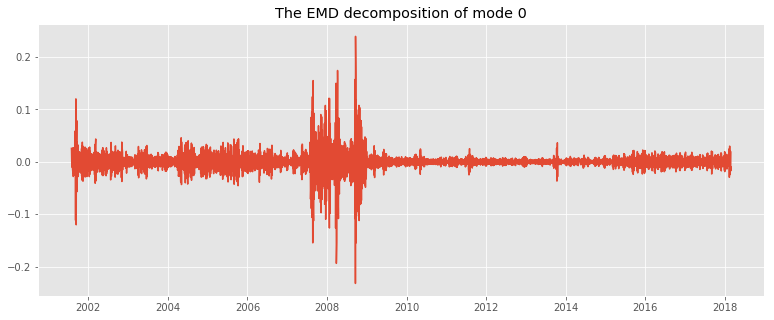

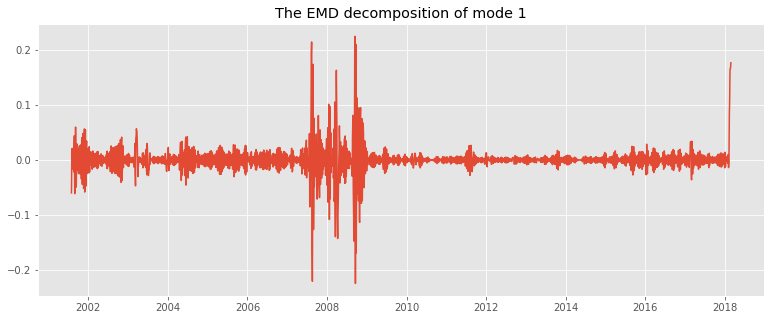

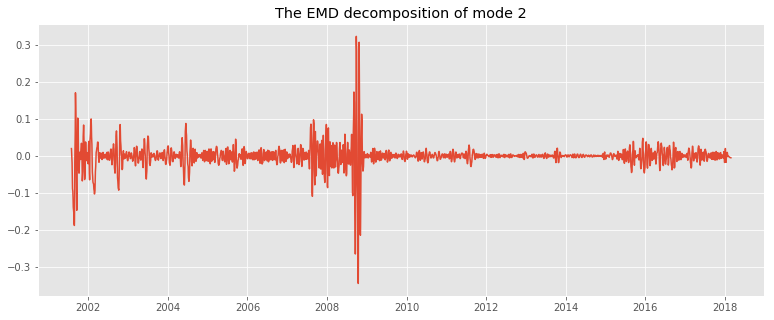

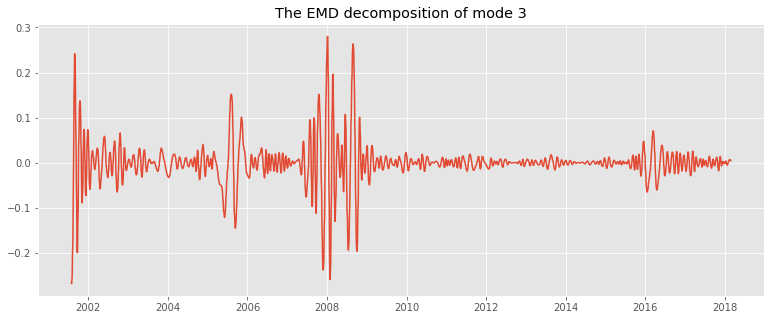

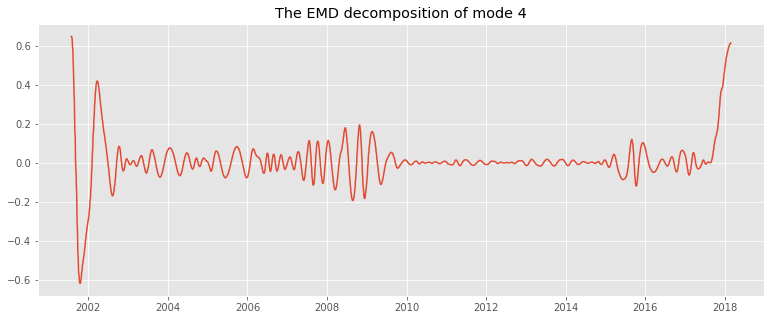

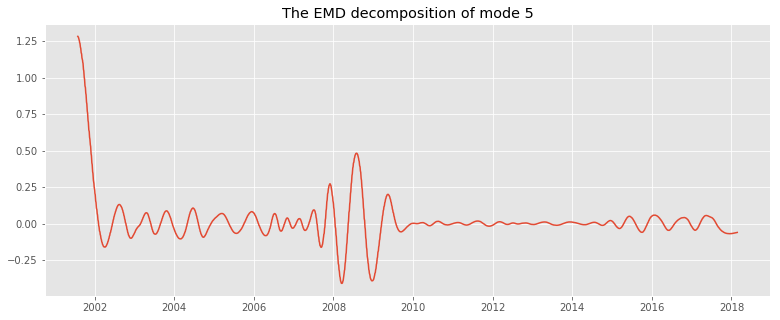

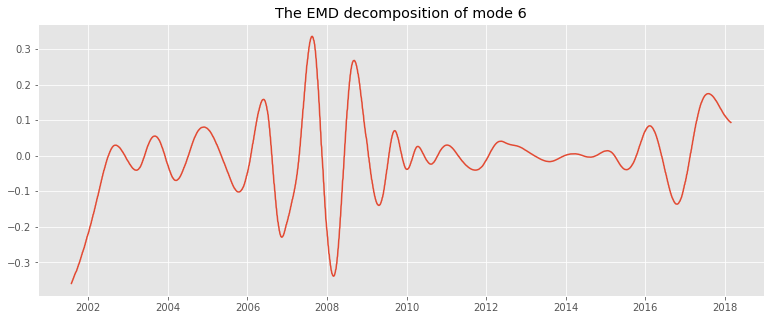

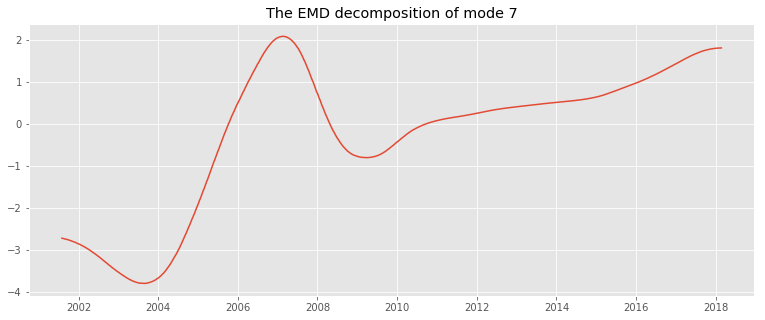

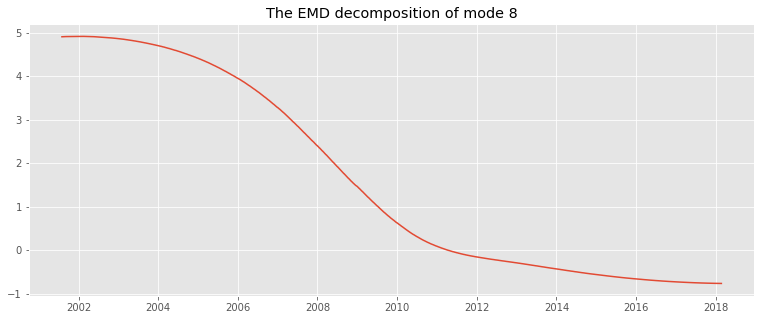

In [14]:
#plt.figure(figsize=(28,17))
#plot_imfs(Treasury_yield_PCA["20 YR"], imfs, Treasury_yield_PCA.index, fignum=5) 
#help(plot_imfs) #6 MO
for index, mode in enumerate(imfs):
    plt.figure(figsize = (13, 5))
    plt.plot(Treasury_yield_PCA.index, mode)
    plt.title("The EMD decomposition of mode %d"% index)
    plt.show()

The term measures the orthogonality coefficient $\sum_{i, j=1, i \neq j}^{N} \frac{|C_{i}\overline{C_{j}}|}{|x|^2}$.

In [15]:
print('%.3f' % decomposer.io())

0.743


In [16]:
from pyhht.utils import extr
from pyhht.utils import inst_freq
indmin, indmax, indzer = extr(imfs[3])
instf, timestamps = inst_freq(imfs[3])

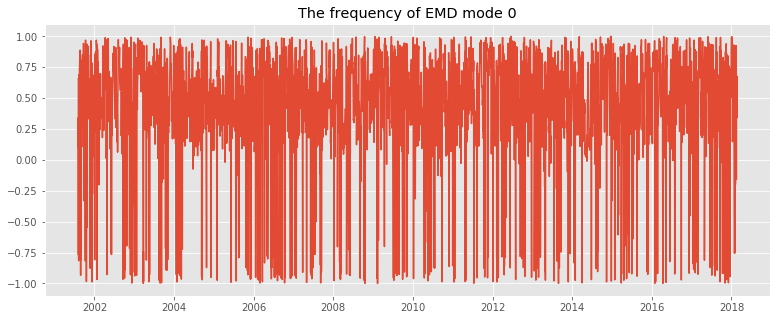

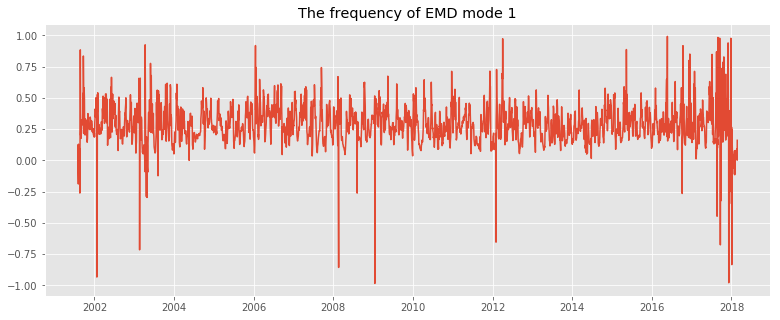

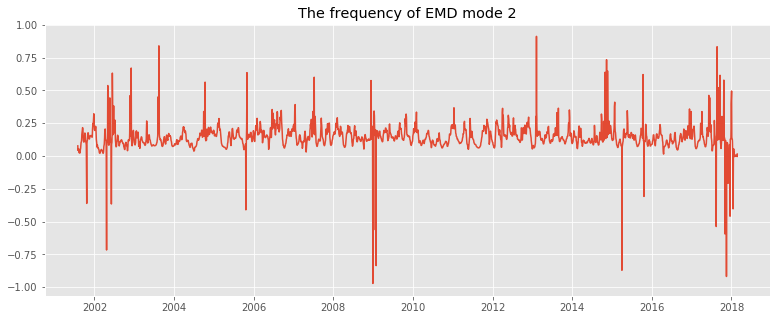

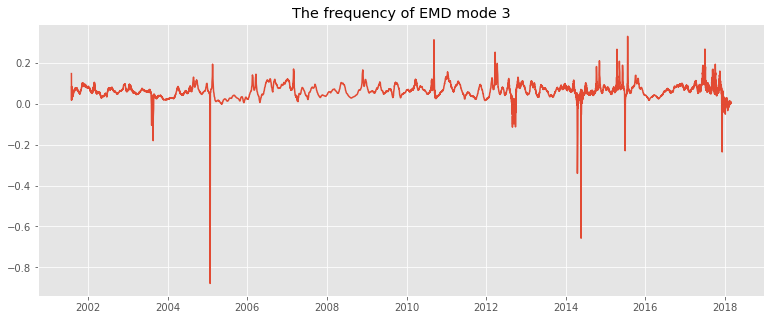

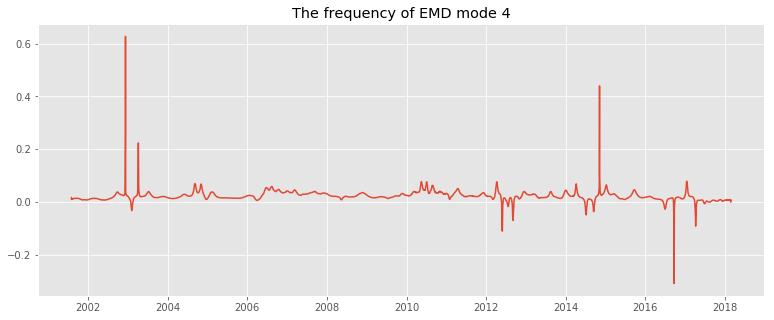

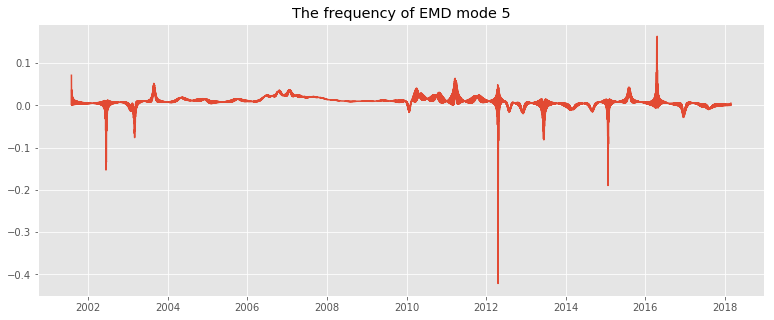

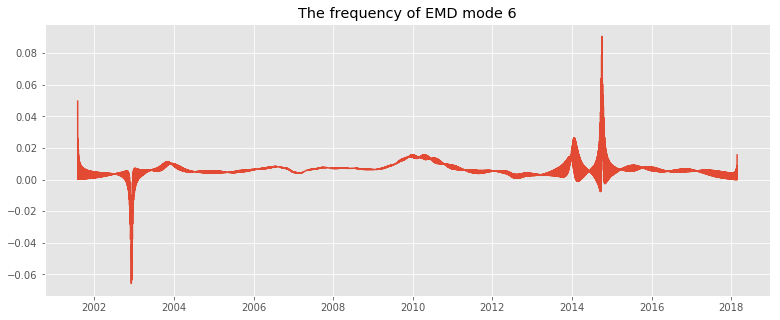

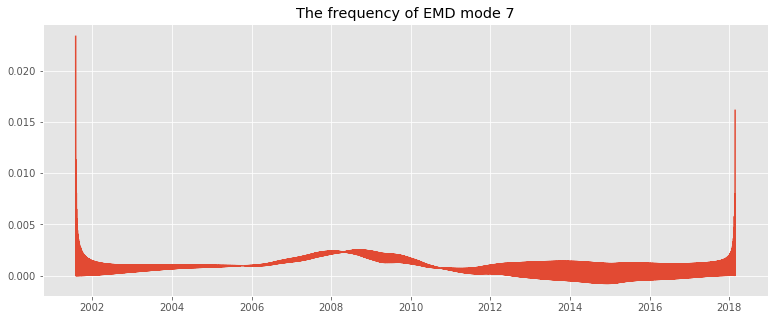

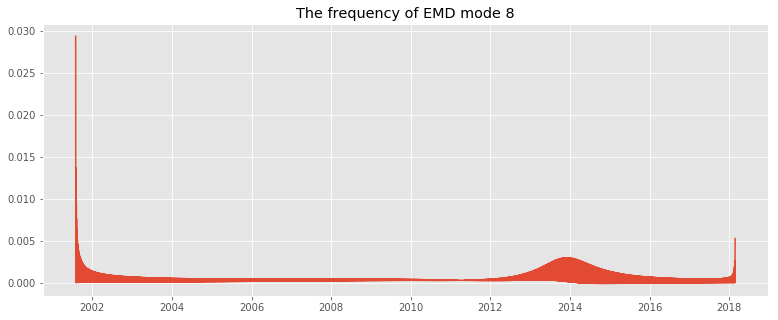

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
fs = 2.0
# plot the frequency
freq_mat = []
index_row = []
for index, imf in enumerate(imfs):
    signal = imf
    analytic_signal = hilbert(signal)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency = (np.diff(instantaneous_phase) /
                           (2.0*np.pi) * fs)
    freq_mat.append(instantaneous_frequency)
    index_row.append("frequency of mode {}".format(index))
    plt.figure(figsize = (13, 5))
    plt.plot(Treasury_yield_PCA.index[1:], instantaneous_frequency)
    plt.title("The frequency of EMD mode %d"% index)
    plt.show()

In [19]:
# construct the matrix
freq_df = pd.DataFrame(np.array(freq_mat).T, index=Treasury_yield_PCA.index[1:], columns=index_row)
freq_df_new = freq_df.drop(["frequency of mode 7", "frequency of mode 8"], axis=1)

In [20]:
# construct the index
def index_generation(dataseries, lookforwardwindow = 5, basis_spread = 5):
    """
    This function generate the index for the input data series.
    Basically it consider the difference between the current data and
    the one with look forward window. If the difference is greater than
    basis spread, then it will be classified as 1, -1 if less then the negative
    basis spread, and 0 otherwise
    """
    index_fac = []
    percent_move = basis_spread/10000
    for index, element in enumerate(dataseries):
        if index + lookforwardwindow < len(dataseries):
            if dataseries[index + lookforwardwindow] - element < -percent_move:
                index_fac.append(1)
            elif dataseries[index + lookforwardwindow] - element > percent_move:
                index_fac.append(-1)
            else:
                index_fac.append(0)
                
    return index_fac


In [66]:
lookforwardwindow = 5
index_6_MO = index_generation(Treasury_yield_data["6 MO"], 
                             lookforwardwindow = lookforwardwindow, basis_spread = 10)
index_6_MO_df = pd.DataFrame(index_20YR, index=Treasury_yield_data.index[:-lookforwardwindow], columns=["trading_index"]
                            )

In [82]:
# The trainning process using Multiple Layer Perceptron
from sklearn.neural_network import MLPClassifier
train_start_date = freq_df.index[0]
train_end_date = freq_df.index[0] + pd.DateOffset(900)
test_start = train_end_date + pd.DateOffset(1)
test_end = test_start + pd.DateOffset(400)
X_train = freq_df_new.loc[train_start_date:train_end_date]
X_test = freq_df_new.loc[test_start:test_end]
Y_train = index_6_MO_df[train_start_date:train_end_date]
Y_train = np.ravel(Y_train)
Y_test = index_6_MO_df[test_start:test_end]
Y_test = np.ravel(Y_test)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(43, 15), random_state=1)

from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test) 

clf.fit(X_train, Y_train)  

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(43, 15), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [83]:
# obtain the prediction data
from sklearn.metrics import confusion_matrix
Y_pred = clf.predict(X_test)
CM = confusion_matrix(Y_test, Y_pred)
index = [-1, 0, 1]
CM = pd.DataFrame(CM, index=index, columns=index)
fmt.displayDFs(CM)

,-1,0,1
-1,94,24,86
0,6,4,13
1,22,12,13


In [84]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth=4, class_weight = "balanced")
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
CM = confusion_matrix(Y_test, Y_pred)
CM = pd.DataFrame(CM, index=index, columns=index)
fmt.displayDFs(CM)

,-1,0,1
-1,136,14,54
0,7,9,7
1,26,11,10


In [85]:
from sklearn import svm
class_weights = {-1:2, 0:3, 1:1.3}
clf = svm.SVC(decision_function_shape='ovo', class_weight=class_weights)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)
CM = confusion_matrix(Y_test, Y_pred)
CM = pd.DataFrame(CM, index=index, columns=index)
fmt.displayDFs(CM)


,-1,0,1
-1,117,11,76
0,8,8,7
1,24,9,14
